<a href="https://colab.research.google.com/github/talhaanwarch/my_pytorch/blob/master/advance/HC_18_PL_qubvel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# resources
#https://github.com/Pankaj1357

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# install packages

In [3]:
%%capture
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install pytorch-lightning
!pip install torchmetrics
!pip install segmentation-models-pytorch
!pip install --upgrade albumentations

In [4]:
import albumentations as A
A.__version__ 

'1.0.1'

In [5]:
import pytorch_lightning as PL
PL.__version__

'1.3.8'

# download and extract data

In [6]:
%%capture
import os
if os.path.isfile('training_set.zip') is False:
  !wget https://zenodo.org/record/1327317/files/training_set.zip
  !wget https://zenodo.org/record/1327317/files/training_set_pixel_size_and_HC.csv
  !wget https://zenodo.org/record/1327317/files/test_set_pixel_size.csv
  !wget https://zenodo.org/record/1327317/files/test_set.zip

In [7]:
%%capture
!unzip /content/training_set.zip
!unzip /content/test_set.zip

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [9]:
train_df=pd.read_csv('/content/training_set_pixel_size_and_HC.csv')
train_df.head()

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [10]:
test_df=pd.read_csv('/content/test_set_pixel_size.csv')
test_df.head()

,filename,pixel size(mm)
0,000_HC.png,0.235857
1,001_HC.png,0.067973
2,002_HC.png,0.165202
3,003_HC.png,0.096674
4,004_HC.png,0.202203


Text(0.5, 1.0, 'Image Annotation')

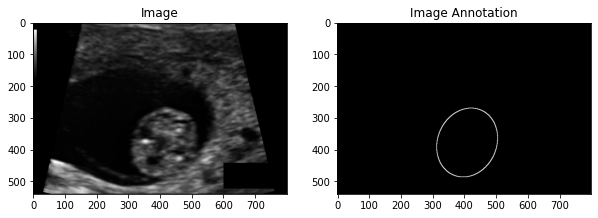

In [11]:
img=cv2.imread('/content/training_set/000_HC.png',0)
img_annot=cv2.imread('/content/training_set/000_HC_Annotation.png',0)
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(img_annot,cmap='gray')
ax[1].set_title('Image Annotation')


In [12]:
#convert this circle to a mask
def masking(image):
    ret, thresh = cv2.threshold(image, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = cv2.fitEllipse(contours[0])
    return cv2.ellipse(image, ellipse, (255,255,255), -1)

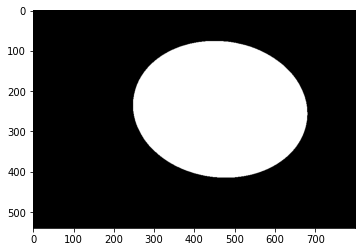

In [13]:
img=cv2.imread('/content/training_set/168_HC_Annotation.png',0)
plt.imshow(masking(img),cmap='gray')

## <font color='red'> run following cell one time only </font>

In [14]:
#do this will all images annotation
images_path,mask_path=[],[]
for img_path in sorted(glob('/content/training_set/*.png')):
  if 'Annotation' in img_path:
    mask_path.append(img_path)#get path of all masks
    image=cv2.imread(img_path,0)
    image=masking(image)
    cv2.imwrite(img_path, image)
  else:
    images_path.append(img_path)#get path of all images
    


Text(0.5, 1.0, 'Image Annotation')

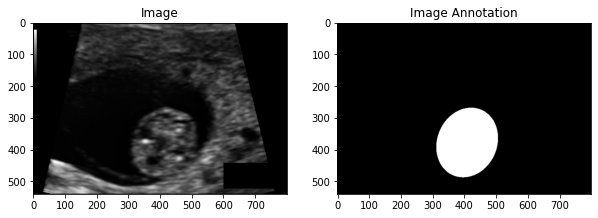

In [15]:
img=cv2.imread('/content/training_set/000_HC.png',0)
img_annot=cv2.imread('/content/training_set/000_HC_Annotation.png',0)
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(img_annot,cmap='gray')
ax[1].set_title('Image Annotation')


In [16]:
len(images_path),len(mask_path)

(999, 999)

# image augmentation

In [17]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

aug= A.Compose([
            A.Resize(224, 224),
            #CenterCrop(224,224),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(60), 
            #A.ShiftScaleRotate(2,2,5), 
            #A.Cutout(p=0.5),
            A.Normalize(mean=(0), std=(1)),
            ToTensorV2(p=1.0),
        ], p=1.0)

# creater loader

In [18]:
from torch.utils.data import DataLoader, Dataset
import torchvision

In [43]:
class Reader(Dataset):
  def __init__(self,images,labels,transform=None):
    super(Reader,self).__init__()
    self.images=images
    self.masks=labels
    self.transform=transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self,index):
    image_path=self.images[index]
    mask_path=self.masks[index]

    image=cv2.imread(image_path,0)
    mask=cv2.imread(mask_path,0)
    if self.transform:
      transformed =self.transform(image=image,mask=mask)
      image=transformed['image']
      mask=transformed['mask']
      mask=np.expand_dims(mask,0)//255

    return image,mask


torch.Size([8, 1, 224, 224]) torch.Size([8, 1, 224, 224])


Text(0.5, 1.0, 'batch of masks')

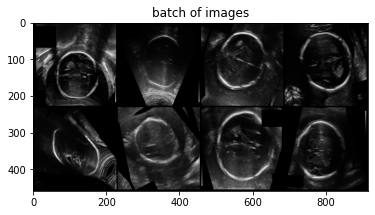

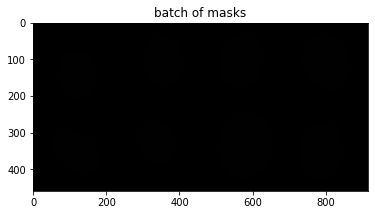

In [44]:
#testing above code
batch=next(iter(DataLoader(Reader(images_path,mask_path,aug), batch_size = 8, num_workers=1,shuffle=True)))
print(batch[0].shape,batch[1].shape)
plt.figure()
grid_img=torchvision.utils.make_grid(batch[0],4,4)
plt.imshow(grid_img.permute(1, 2, 0))
plt.title('batch of images')
plt.figure()
grid_img=torchvision.utils.make_grid(batch[1],4,4)
plt.imshow(grid_img.permute(1, 2, 0))
plt.title('batch of masks')


In [45]:
# model = smp.Unet(
#                 encoder_name='resnet18',        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#                 encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#                 in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#                 classes=1,    # model output channels (number of classes in your dataset)
#                 activation='sigmoid'    # could be None for logits or 'softmax2d' for multiclass segmentation               
# )

In [46]:
# x=torch.randn(1,1,224,224)
# y=torch.randn(1,1,224,224)

# out=model(x)
# print(out.shape)

In [47]:
# metrics = smp.utils.metrics.IoU(threshold=0.5)
# metrics(y,out)

#create model setup

In [48]:
from sklearn.model_selection import train_test_split
train_images,val_images,train_masks,val_masks=train_test_split(images_path,mask_path,test_size=0.2)

In [49]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import segmentation_models_pytorch as smp
import torchmetrics

import torch.nn as nn
import torch

In [53]:
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer = smp.Unet(
                encoder_name='resnet18',        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
                in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                classes=1,    # model output channels (number of classes in your dataset)
                activation='sigmoid'    # could be None for logits or 'softmax2d' for multiclass segmentation               
)


  #parameters
    self.lr=1e-3
    self.batch_size=4
    self.numworker=2
    self.criterion= smp.utils.losses.DiceLoss()
    self.metrics = torchmetrics.IoU(num_classes=2)
    
  def forward(self,x):
    #print(x.max(),x.min())
    return self.layer(x)


  def configure_optimizers(self):
    opt=torch.optim.Adam(self.parameters(), lr=self.lr)
    return opt

  def train_dataloader(self):
    ds = Reader(train_images,train_masks,aug)
    loader = DataLoader(ds, batch_size=self.batch_size)
    return loader

  def training_step(self,batch,batch_idx):
    image,segment=batch
    out=self(image)
    loss=self.criterion(out,segment)
    self.log('train/loss', loss, on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    ds = Reader(val_images,val_masks,aug)
    loader = DataLoader(ds, batch_size=self.batch_size)
    return loader
    
  def validation_step(self,batch,batch_idx):
    image,segment=batch
    out=self(image)
    loss=self.criterion(out,segment)
    iou=self.metrics(out.type(torch.long),segment.type(torch.long))
    self.log('val/loss', loss, on_epoch=True,prog_bar=True)
    self.log('val/iou', iou, on_epoch=True,prog_bar=True)
    return loss

In [54]:
model = OurModel()
logger = TensorBoardLogger("logs", name="my_logs")
checkpoint_callback = ModelCheckpoint(monitor='val/loss',dirpath='/content/drive/MyDrive/',
                                      filename='covidctmd' )
trainer = Trainer(max_epochs=1, auto_lr_find=False, auto_scale_batch_size=False,
                  tpu_cores=8,precision=16,
                  logger=logger,
                  callbacks=[checkpoint_callback],
                  progress_bar_refresh_rate=30)

GPU available: False, used: False
TPU available: True, using: 8 TPU cores


In [55]:
trainer.fit(model)


  | Name      | Type     | Params
---------------------------------------
0 | layer     | Unet     | 14.3 M
1 | criterion | DiceLoss | 0     
2 | metrics   | IoU      | 0     
---------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
28.644    Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/plugins/training_type/tpu_spawn.py:193: UserWarning: cleaning up ddp environment...
  rank_zero_warn("cleaning up ddp environment...")


In [ ]:
test_loader=model.val_dataloader()
model.eval()
with torch.no_grad():
  imgs,preds,labels=[],[],[]
  for img, seg in test_loader:
    pred=model(img)
    img=img.detach().numpy()
    pred=pred.detach().numpy()
    seg=seg.detach().numpy()
    imgs.append(img)
    preds.append(pred)
    labels.append(seg)

In [ ]:
img.shape,pred.shape,seg.shape


In [ ]:
imgs_array=np.concatenate(imgs)
preds_array=np.concatenate(preds)
labels_array=np.concatenate(labels)
imgs_array.shape,preds_array.shape,labels_array.shape

In [ ]:
fig,ax=plt.subplots(3,3,figsize=(16,8))
for i in range(3):
  ax[i,0].imshow(imgs_array[i,0,:,:],cmap='gray')
  ax[i,0].set_title('image_{}'.format(i))
  ax[i,1].imshow(labels_array[i,0,:,:],cmap='gray')
  ax[i,1].set_title('segment_{}'.format(i))
  ax[i,2].imshow(preds_array[i,0,:,:],cmap='gray')
  ax[i,2].set_title('predicted_{}'.format(i))
plt.subplots_adjust(wspace=-0.7, hspace=0.4)

In [ ]:
print(labels_array.reshape(200,-1).shape,preds_array.reshape(200,-1).shape)

In [ ]:
import torchmetrics
pred=torch.tensor(preds_array.astype(int).reshape(200,-1)*255)
target=torch.tensor(labels_array.reshape(200,-1))

iou=torchmetrics.IoU(num_classes=2)
iou(pred,target)

In [ ]:
from sklearn.metrics import jaccard_score
jaccard_score(labels_array.reshape(200,-1),preds_array.astype(int).reshape(200,-1))

In [ ]:
!rm -rf /content/training_set
!rm -rf /content/test_set